In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Installer TensorFlow si nécessaire
!pip install tensorflow

# Importer les bibliothèques
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [ ]:
import os

# 🔹 Chemins des dossiers
train_dir = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train"
val_dir   = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val"
test_dir  = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test"

def count_images_per_class(directory):
    print(f"\n Répartition des images dans {directory}:")
    total = 0
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            n_images = len(os.listdir(class_path))
            total += n_images
            print(f"  - {class_name} : {n_images} images")
    print(f"Total images : {total}\n")

# 🔹 Affichage du nombre d'images
count_images_per_class(train_dir)
count_images_per_class(val_dir)
count_images_per_class(test_dir)



 Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train:
  - COVID : 3301 images
  - Normal : 7134 images
  - Viral Pneumonia : 941 images
Total images : 11376


 Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val:
  - COVID : 1195 images
  - Normal : 2038 images
  - Viral Pneumonia : 269 images
Total images : 3502


 Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test:
  - COVID : 362 images
  - Normal : 1020 images
  - Viral Pneumonia : 135 images
Total images : 1517



In [ ]:
# Définir les chemins
train_dir = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train"
val_dir   = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val"
test_dir  = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test"

# Classes
classes = ['COVID', 'Normal', 'Viral Pneumonia']

print("Chemins configurés:")
print(f"Train: {train_dir}")
print(f"Val:   {val_dir}")
print(f"Test:  {test_dir}")
print(f"Classes: {classes}")

Chemins configurés:
Train: /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train
Val:   /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val
Test:  /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test
Classes: ['COVID', 'Normal', 'Viral Pneumonia']


In [ ]:
def count_images_per_class(directory):
    print(f"\nRépartition des images dans {directory}:")
    total = 0
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            n_images = len([f for f in os.listdir(class_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
            total += n_images
            print(f"  - {class_name}: {n_images} images")
    print(f"Total images: {total}")
    return total

# 🔹 Affichage du nombre d'images
train_count = count_images_per_class(train_dir)
val_count = count_images_per_class(val_dir)
test_count = count_images_per_class(test_dir)

print(f"\n📊 Résumé total:")
print(f"Train: {train_count} images")
print(f"Val:   {val_count} images")
print(f"Test:  {test_count} images")
print(f"Total: {train_count + val_count + test_count} images")


Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train:
  - COVID: 3301 images
  - Normal: 7134 images
  - Viral Pneumonia: 941 images
Total images: 11376

Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val:
  - COVID: 1195 images
  - Normal: 2038 images
  - Viral Pneumonia: 269 images
Total images: 3502

Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test:
  - COVID: 362 images
  - Normal: 1020 images
  - Viral Pneumonia: 135 images
Total images: 1517

📊 Résumé total:
Train: 11376 images
Val:   3502 images
Test:  1517 images
Total: 16395 images


In [ ]:
# Importer les bibliothèques
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

print(f"TensorFlow version: {tf.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.19.0


Found 11376 images belonging to 3 classes.
Found 3502 images belonging to 3 classes.
Found 1517 images belonging to 3 classes.

✓ Générateurs créés
Classes mapping: {'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}
Train samples: 11376
Val samples: 3502
Test samples: 1517


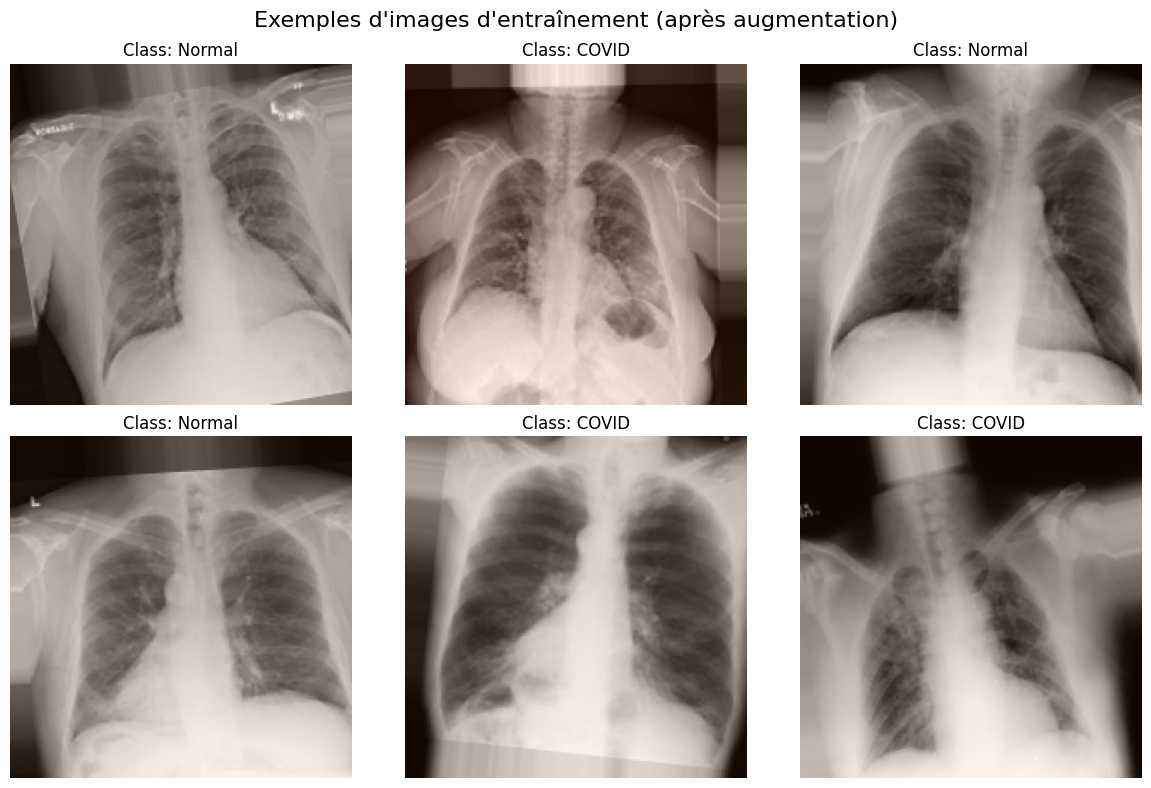

In [ ]:
# Augmentation de données pour l'entraînement
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Pas d'augmentation pour validation et test
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Générateur d'entraînement
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    classes=classes
)

# Générateur de validation
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=classes
)

# Générateur de test
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=classes
)

print("\n✓ Générateurs créés")
print(f"Classes mapping: {train_generator.class_indices}")
print(f"Train samples: {train_generator.samples}")
print(f"Val samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Afficher un exemple d'images
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    batch = next(train_generator)
    image = batch[0][0]
    # Dénormaliser pour l'affichage
    image = image - image.min()
    image = image / image.max()
    plt.imshow(image)
    plt.title(f"Class: {classes[np.argmax(batch[1][0])]}")
    plt.axis('off')
plt.suptitle('Exemples d\'images d\'entraînement (après augmentation)', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
#  le modèle ResNet50
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(200, 200, 3)
)

# Geler les couches du modèle de base (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# Déverrouiller les dernières couches
for layer in base_model.layers[-20:]:
    layer.trainable = True

print("✓ Modèle ResNet50 créé")
print(f"Total layers: {len(base_model.layers)}")
print(f"Trainable layers: {sum([1 for layer in base_model.layers if layer.trainable])}")

✓ Modèle ResNet50 créé
Total layers: 175
Trainable layers: 20


# Architecture robuste
- **Skip connections** : Résout le problème de vanishing gradient
- **50 couches profondes** : Capture des features complexes
- **Pré-entraîné sur ImageNet** : Connaissance transférable
- **Batch Normalization** : Stabilise l'apprentissage

In [ ]:
# Ajouter des couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(3, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=output)

print("✓ Couches personnalisées ajoutées")

✓ Couches personnalisées ajoutées


In [ ]:
# Importer BatchNormalization
from tensorflow.keras.layers import BatchNormalization

# Compiler le modèle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

# Afficher le résumé
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 24,771,971 (94.50 MB)

 Trainable params: 10,114,051 (38.58 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

In [ ]:
# Définir les callbacks
checkpoint_path = "/content/drive/MyDrive/COVID_XRay_Project/best_model.h5"

callbacks = [
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print(f"✓ Checkpoint sera sauvegardé à: {checkpoint_path}")

✓ Checkpoint sera sauvegardé à: /content/drive/MyDrive/COVID_XRay_Project/best_model.h5


In [ ]:
# Calculer les steps par epoch
train_steps = int(np.ceil(train_generator.samples / train_generator.batch_size))
val_steps = int(np.ceil(val_generator.samples / val_generator.batch_size))

print(f"Train steps per epoch: {train_steps}")
print(f"Val steps per epoch: {val_steps}")

# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

print("✓ Entraînement terminé")

Train steps per epoch: 356
Val steps per epoch: 110
Epoch 1/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6961 - auc: 0.8449 - loss: 0.7902 - precision: 0.7204 - recall: 0.6608
Epoch 1: val_accuracy improved from -inf to 0.93489, saving model to /content/drive/MyDrive/COVID_XRay_Project/best_model.h5


356/356 ━━━━━━━━━━━━━━━━━━━━ 228s 578ms/step - accuracy: 0.6965 - auc: 0.8452 - loss: 0.7894 - precision: 0.7208 - recall: 0.6612 - val_accuracy: 0.9349 - val_auc: 0.9881 - val_loss: 0.2006 - val_precision: 0.9376 - val_recall: 0.9306 - learning_rate: 1.0000e-04
Epoch 2/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9176 - auc: 0.9833 - loss: 0.2351 - precision: 0.9225 - recall: 0.9135
Epoch 2: val_accuracy improved from 0.93489 to 0.95488, saving model to /content/drive/MyDrive/COVID_XRay_Project/best_model.h5


356/356 ━━━━━━━━━━━━━━━━━━━━ 193s 543ms/step - accuracy: 0.9176 - auc: 0.9833 - loss: 0.2350 - precision: 0.9225 - recall: 0.9135 - val_accuracy: 0.9549 - val_auc: 0.9926 - val_loss: 0.1479 - val_precision: 0.9559 - val_recall: 0.9543 - learning_rate: 1.0000e-04
Epoch 3/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9475 - auc: 0.9929 - loss: 0.1476 - precision: 0.9505 - recall: 0.9458
Epoch 3: val_accuracy improved from 0.95488 to 0.95603, saving model to /content/drive/MyDrive/COVID_XRay_Project/best_model.h5


356/356 ━━━━━━━━━━━━━━━━━━━━ 194s 545ms/step - accuracy: 0.9475 - auc: 0.9929 - loss: 0.1476 - precision: 0.9505 - recall: 0.9458 - val_accuracy: 0.9560 - val_auc: 0.9940 - val_loss: 0.1360 - val_precision: 0.9563 - val_recall: 0.9555 - learning_rate: 1.0000e-04
Epoch 4/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9551 - auc: 0.9932 - loss: 0.1382 - precision: 0.9572 - recall: 0.9543
Epoch 4: val_accuracy improved from 0.95603 to 0.96973, saving model to /content/drive/MyDrive/COVID_XRay_Project/best_model.h5


356/356 ━━━━━━━━━━━━━━━━━━━━ 202s 568ms/step - accuracy: 0.9551 - auc: 0.9932 - loss: 0.1382 - precision: 0.9572 - recall: 0.9543 - val_accuracy: 0.9697 - val_auc: 0.9969 - val_loss: 0.0935 - val_precision: 0.9700 - val_recall: 0.9697 - learning_rate: 1.0000e-04
Epoch 5/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9601 - auc: 0.9959 - loss: 0.1118 - precision: 0.9610 - recall: 0.9586
Epoch 5: val_accuracy improved from 0.96973 to 0.97459, saving model to /content/drive/MyDrive/COVID_XRay_Project/best_model.h5


356/356 ━━━━━━━━━━━━━━━━━━━━ 195s 547ms/step - accuracy: 0.9601 - auc: 0.9959 - loss: 0.1118 - precision: 0.9610 - recall: 0.9586 - val_accuracy: 0.9746 - val_auc: 0.9977 - val_loss: 0.0775 - val_precision: 0.9749 - val_recall: 0.9743 - learning_rate: 1.0000e-04
Epoch 6/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9587 - auc: 0.9946 - loss: 0.1174 - precision: 0.9595 - recall: 0.9576
Epoch 6: val_accuracy improved from 0.97459 to 0.97544, saving model to /content/drive/MyDrive/COVID_XRay_Project/best_model.h5


356/356 ━━━━━━━━━━━━━━━━━━━━ 194s 545ms/step - accuracy: 0.9587 - auc: 0.9946 - loss: 0.1174 - precision: 0.9596 - recall: 0.9576 - val_accuracy: 0.9754 - val_auc: 0.9977 - val_loss: 0.0809 - val_precision: 0.9760 - val_recall: 0.9749 - learning_rate: 1.0000e-04
Epoch 7/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9675 - auc: 0.9960 - loss: 0.1028 - precision: 0.9681 - recall: 0.9661
Epoch 7: val_accuracy did not improve from 0.97544
356/356 ━━━━━━━━━━━━━━━━━━━━ 195s 547ms/step - accuracy: 0.9675 - auc: 0.9960 - loss: 0.1028 - precision: 0.9681 - recall: 0.9661 - val_accuracy: 0.9717 - val_auc: 0.9977 - val_loss: 0.0831 - val_precision: 0.9720 - val_recall: 0.9717 - learning_rate: 1.0000e-04
Epoch 8/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9701 - auc: 0.9969 - loss: 0.0922 - precision: 0.9703 - recall: 0.9697
Epoch 8: val_accuracy improved from 0.97544 to 0.97658, saving model to /content/drive/MyDrive/COVID_XRay_Project/best_model.h5


356/356 ━━━━━━━━━━━━━━━━━━━━ 190s 534ms/step - accuracy: 0.9701 - auc: 0.9969 - loss: 0.0922 - precision: 0.9703 - recall: 0.9697 - val_accuracy: 0.9766 - val_auc: 0.9972 - val_loss: 0.0787 - val_precision: 0.9777 - val_recall: 0.9766 - learning_rate: 1.0000e-04
Epoch 9/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9759 - auc: 0.9975 - loss: 0.0735 - precision: 0.9763 - recall: 0.9758
Epoch 9: val_accuracy improved from 0.97658 to 0.98030, saving model to /content/drive/MyDrive/COVID_XRay_Project/best_model.h5


356/356 ━━━━━━━━━━━━━━━━━━━━ 194s 545ms/step - accuracy: 0.9759 - auc: 0.9975 - loss: 0.0735 - precision: 0.9763 - recall: 0.9758 - val_accuracy: 0.9803 - val_auc: 0.9980 - val_loss: 0.0670 - val_precision: 0.9803 - val_recall: 0.9800 - learning_rate: 1.0000e-04
Epoch 10/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9775 - auc: 0.9980 - loss: 0.0668 - precision: 0.9778 - recall: 0.9767
Epoch 10: val_accuracy did not improve from 0.98030
356/356 ━━━━━━━━━━━━━━━━━━━━ 190s 534ms/step - accuracy: 0.9775 - auc: 0.9980 - loss: 0.0668 - precision: 0.9778 - recall: 0.9767 - val_accuracy: 0.9792 - val_auc: 0.9972 - val_loss: 0.0678 - val_precision: 0.9794 - val_recall: 0.9789 - learning_rate: 1.0000e-04
Epoch 11/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9778 - auc: 0.9978 - loss: 0.0708 - precision: 0.9784 - recall: 0.9777
Epoch 11: val_accuracy did not improve from 0.98030
356/356 ━━━━━━━━━━━━━━━━━━━━ 185s 521ms/step - accuracy: 0.9778 - auc: 0.9978 - loss: 0.07

356/356 ━━━━━━━━━━━━━━━━━━━━ 199s 559ms/step - accuracy: 0.9782 - auc: 0.9983 - loss: 0.0601 - precision: 0.9788 - recall: 0.9778 - val_accuracy: 0.9829 - val_auc: 0.9986 - val_loss: 0.0496 - val_precision: 0.9829 - val_recall: 0.9829 - learning_rate: 1.0000e-04
Epoch 13/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9799 - auc: 0.9983 - loss: 0.0560 - precision: 0.9802 - recall: 0.9799
Epoch 13: val_accuracy did not improve from 0.98287
356/356 ━━━━━━━━━━━━━━━━━━━━ 192s 538ms/step - accuracy: 0.9799 - auc: 0.9983 - loss: 0.0561 - precision: 0.9802 - recall: 0.9799 - val_accuracy: 0.9823 - val_auc: 0.9981 - val_loss: 0.0613 - val_precision: 0.9823 - val_recall: 0.9823 - learning_rate: 1.0000e-04
Epoch 14/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9790 - auc: 0.9977 - loss: 0.0643 - precision: 0.9790 - recall: 0.9787
Epoch 14: val_accuracy improved from 0.98287 to 0.98515, saving model to /content/drive/MyDrive/COVID_XRay_Project/best_model.h5


356/356 ━━━━━━━━━━━━━━━━━━━━ 201s 536ms/step - accuracy: 0.9790 - auc: 0.9977 - loss: 0.0643 - precision: 0.9790 - recall: 0.9787 - val_accuracy: 0.9852 - val_auc: 0.9986 - val_loss: 0.0527 - val_precision: 0.9852 - val_recall: 0.9852 - learning_rate: 1.0000e-04
Epoch 15/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9818 - auc: 0.9988 - loss: 0.0522 - precision: 0.9819 - recall: 0.9817
Epoch 15: val_accuracy did not improve from 0.98515
356/356 ━━━━━━━━━━━━━━━━━━━━ 189s 531ms/step - accuracy: 0.9818 - auc: 0.9988 - loss: 0.0522 - precision: 0.9819 - recall: 0.9817 - val_accuracy: 0.9829 - val_auc: 0.9990 - val_loss: 0.0474 - val_precision: 0.9829 - val_recall: 0.9829 - learning_rate: 1.0000e-04
Epoch 16/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9806 - auc: 0.9989 - loss: 0.0498 - precision: 0.9808 - recall: 0.9806
Epoch 16: val_accuracy did not improve from 0.98515
356/356 ━━━━━━━━━━━━━━━━━━━━ 185s 518ms/step - accuracy: 0.9806 - auc: 0.9989 - loss: 0.04

356/356 ━━━━━━━━━━━━━━━━━━━━ 190s 533ms/step - accuracy: 0.9852 - auc: 0.9988 - loss: 0.0484 - precision: 0.9854 - recall: 0.9846 - val_accuracy: 0.9877 - val_auc: 0.9982 - val_loss: 0.0482 - val_precision: 0.9877 - val_recall: 0.9877 - learning_rate: 1.0000e-04
Epoch 19/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9871 - auc: 0.9991 - loss: 0.0372 - precision: 0.9873 - recall: 0.9870
Epoch 19: val_accuracy did not improve from 0.98772
356/356 ━━━━━━━━━━━━━━━━━━━━ 200s 525ms/step - accuracy: 0.9871 - auc: 0.9991 - loss: 0.0372 - precision: 0.9872 - recall: 0.9870 - val_accuracy: 0.9849 - val_auc: 0.9978 - val_loss: 0.0671 - val_precision: 0.9849 - val_recall: 0.9849 - learning_rate: 1.0000e-04
Epoch 20/20
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9900 - auc: 0.9996 - loss: 0.0290 - precision: 0.9901 - recall: 0.9899
Epoch 20: val_accuracy did not improve from 0.98772

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
356/356 ━━━━

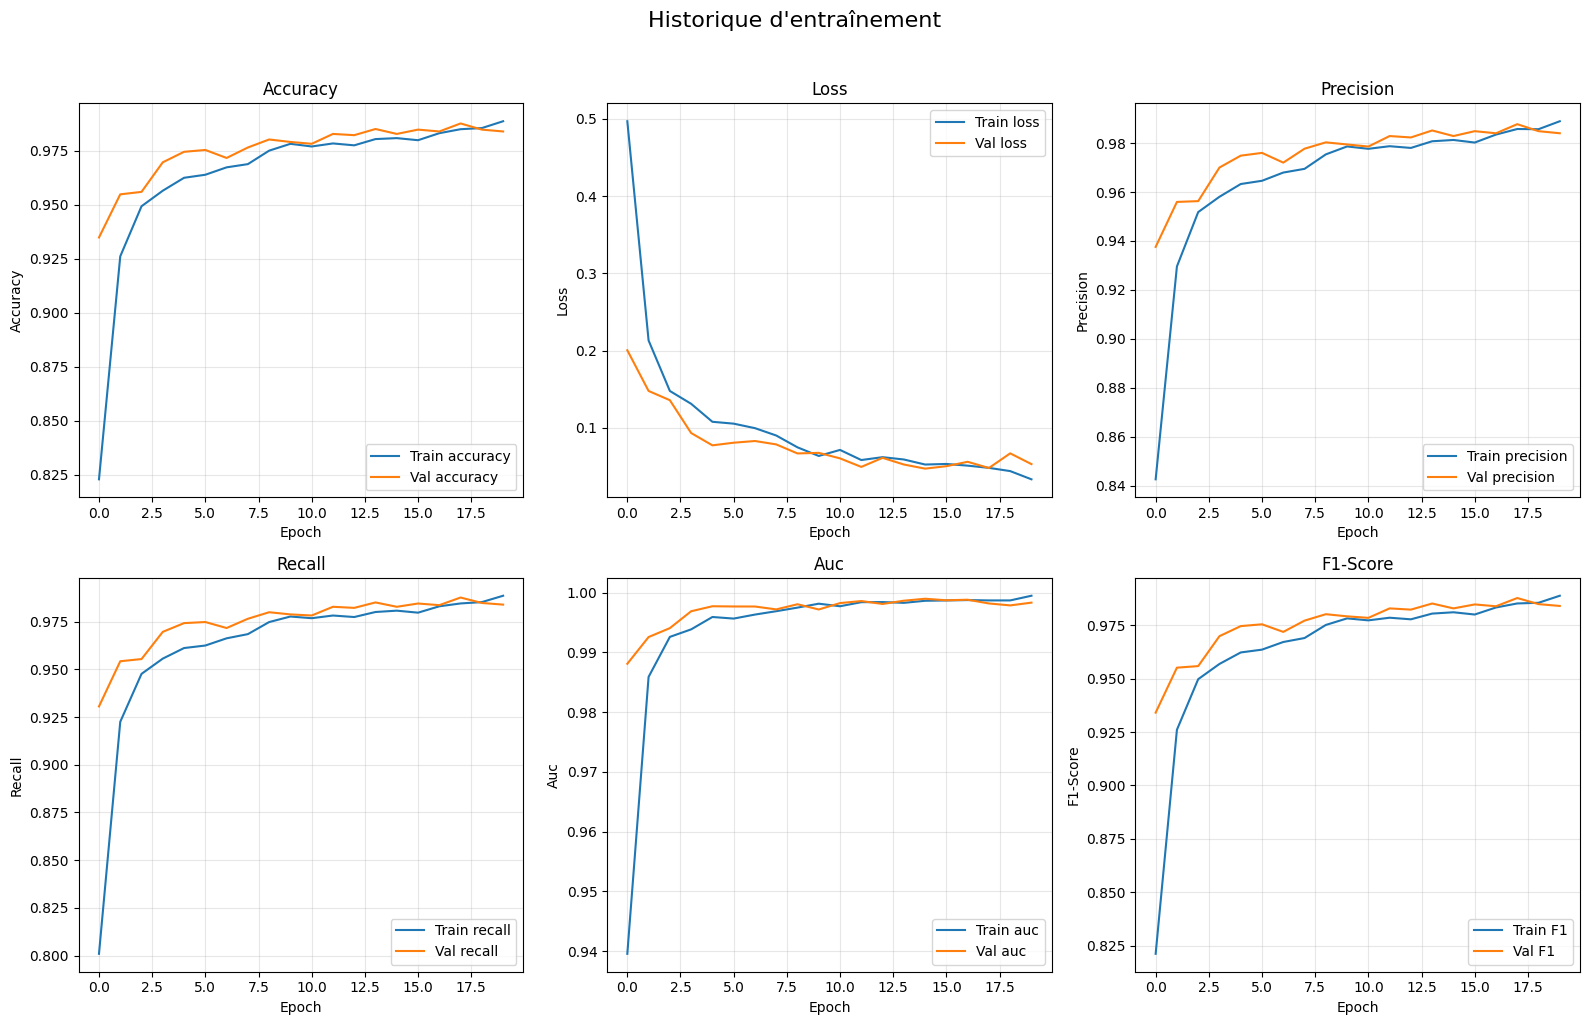

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']

    for idx, metric in enumerate(metrics):
        row = idx // 3
        col = idx % 3

        if metric in history.history:
            axes[row, col].plot(history.history[metric], label=f'Train {metric}')
            axes[row, col].plot(history.history[f'val_{metric}'], label=f'Val {metric}')
            axes[row, col].set_title(metric.capitalize())
            axes[row, col].set_xlabel('Epoch')
            axes[row, col].set_ylabel(metric.capitalize())
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)

    # Calculer et afficher F1-Score
    row, col = 1, 2
    train_f1 = []
    val_f1 = []

    for i in range(len(history.history['precision'])):
        p = history.history['precision'][i]
        r = history.history['recall'][i]
        train_f1.append(2 * (p * r) / (p + r) if (p + r) > 0 else 0)

    for i in range(len(history.history['val_precision'])):
        p = history.history['val_precision'][i]
        r = history.history['val_recall'][i]
        val_f1.append(2 * (p * r) / (p + r) if (p + r) > 0 else 0)

    axes[row, col].plot(train_f1, label='Train F1')
    axes[row, col].plot(val_f1, label='Val F1')
    axes[row, col].set_title('F1-Score')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('F1-Score')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

    plt.suptitle('Historique d\'entraînement', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Charger le meilleur modèle
model.load_weights(checkpoint_path)
print(f"✓ Meilleur modèle chargé depuis: {checkpoint_path}")

# Évaluer sur la validation
print("\nÉvaluation sur l'ensemble de validation:")
val_results = model.evaluate(val_generator, verbose=0)

metric_names = ['loss', 'accuracy', 'precision', 'recall', 'auc']
for name, value in zip(metric_names, val_results):
    print(f"  {name.capitalize()}: {value:.4f}")

# Calculer F1-Score
precision = val_results[2]
recall = val_results[3]
val_f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"  F1-Score: {val_f1:.4f}")

✓ Meilleur modèle chargé depuis: /content/drive/MyDrive/COVID_XRay_Project/best_model.h5

Évaluation sur l'ensemble de validation:
  Loss: 0.0482
  Accuracy: 0.9877
  Precision: 0.9877
  Recall: 0.9877
  Auc: 0.9982
  F1-Score: 0.9877


In [ ]:
# Réinitialiser le générateur de test
test_generator.reset()

# Faire les prédictions
print("Prédictions sur le test set...")
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# Récupérer les vraies étiquettes
y_true = test_generator.classes

print(f"\n✓ Prédictions terminées")
print(f"  Nombre d'images: {len(y_true)}")
print(f"  Shape des prédictions: {y_pred_prob.shape}")

Prédictions sur le test set...
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 277ms/step

✓ Prédictions terminées
  Nombre d'images: 1517
  Shape des prédictions: (1517, 3)


In [ ]:
print("=" * 70)
print("ÉVALUATION DÉTAILLÉE SUR LE TEST SET")
print("=" * 70)

# Vérifier la cohérence
if len(y_true) != len(y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    y_pred_prob = y_pred_prob[:min_len]
    print(f"  Arrays tronqués à {min_len} échantillons")

# Calcul des métriques
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\n MÉTRIQUES GLOBALES (weighted):")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Métriques macro (toutes classes égales)
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"\n MÉTRIQUES GLOBALES (macro):")
print(f"  Precision: {precision_macro:.4f}")
print(f"  Recall:    {recall_macro:.4f}")
print(f"  F1-Score:  {f1_macro:.4f}")

ÉVALUATION DÉTAILLÉE SUR LE TEST SET

📊 MÉTRIQUES GLOBALES (weighted):
  Accuracy:  0.9829 (98.29%)
  Precision: 0.9829
  Recall:    0.9829
  F1-Score:  0.9828

📊 MÉTRIQUES GLOBALES (macro):
  Precision: 0.9819
  Recall:    0.9725
  F1-Score:  0.9771


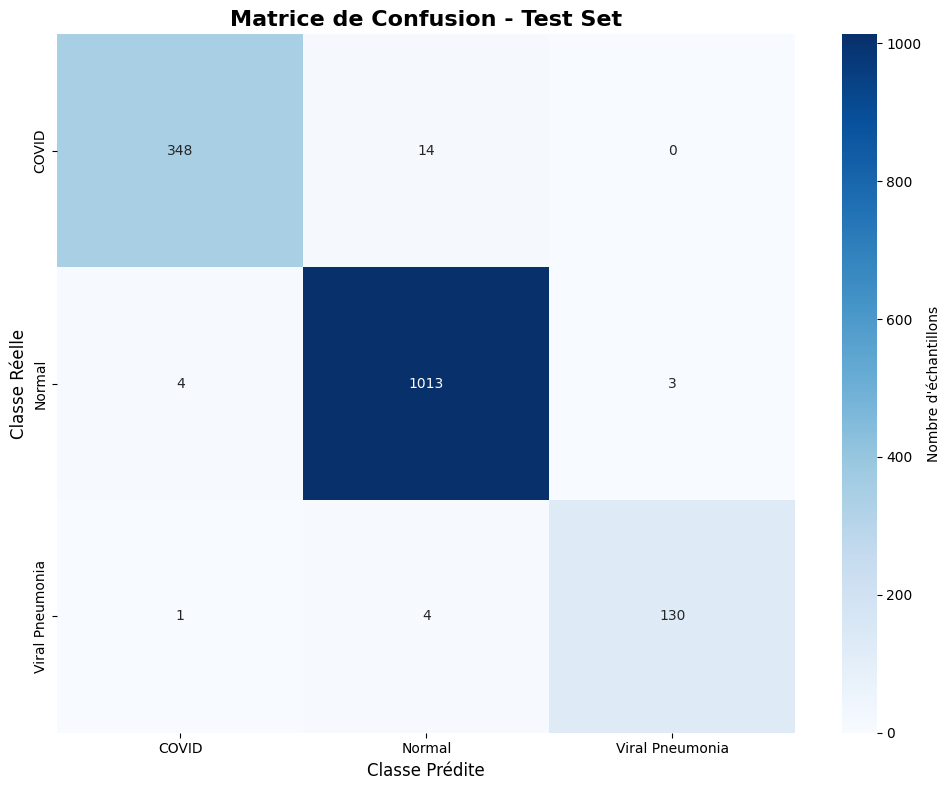

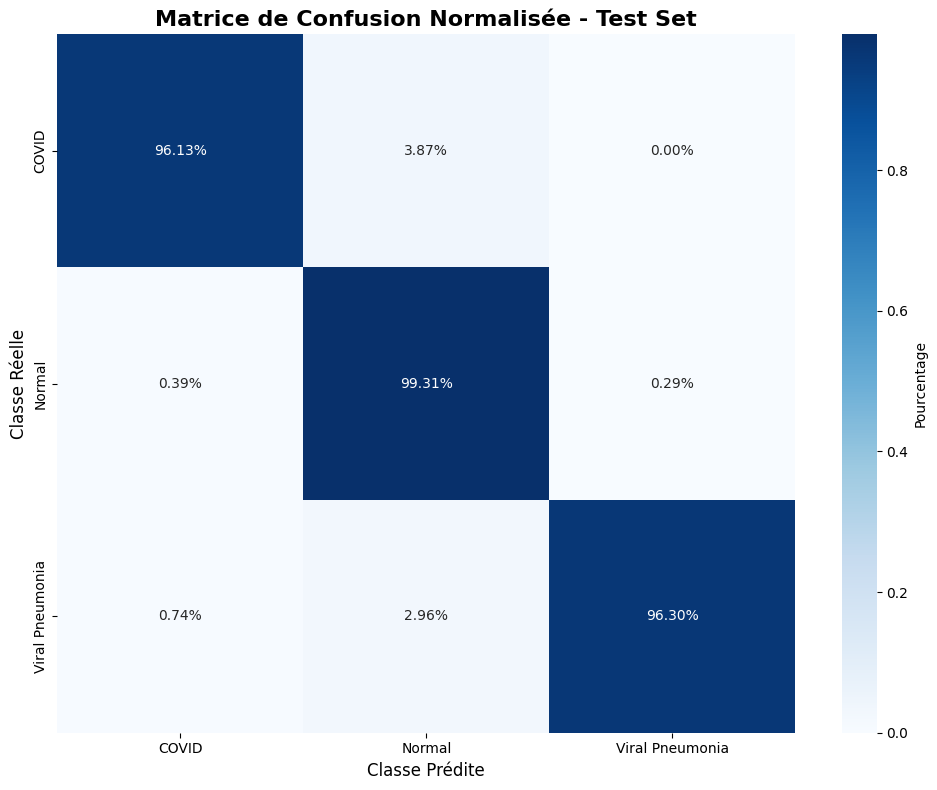

In [ ]:
# Créer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Nombre d\'échantillons'})

plt.title('Matrice de Confusion - Test Set', fontsize=16, fontweight='bold')
plt.ylabel('Classe Réelle', fontsize=12)
plt.xlabel('Classe Prédite', fontsize=12)
plt.tight_layout()
plt.show()

# Matrice de confusion normalisée
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes,
            cbar_kws={'label': 'Pourcentage'})

plt.title('Matrice de Confusion Normalisée - Test Set', fontsize=16, fontweight='bold')
plt.ylabel('Classe Réelle', fontsize=12)
plt.xlabel('Classe Prédite', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
print("=" * 70)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("=" * 70)

# Générer le rapport
report = classification_report(y_true, y_pred,
                               target_names=classes,
                               digits=4)
print(report)

# Convertir en DataFrame
report_dict = classification_report(y_true, y_pred,
                                    target_names=classes,
                                    output_dict=True,
                                    digits=4)

df_report = pd.DataFrame(report_dict).transpose()
print("\n📋 Tableau récapitulatif:")
print(df_report)

RAPPORT DE CLASSIFICATION DÉTAILLÉ
                 precision    recall  f1-score   support

          COVID     0.9858    0.9613    0.9734       362
         Normal     0.9825    0.9931    0.9878      1020
Viral Pneumonia     0.9774    0.9630    0.9701       135

       accuracy                         0.9829      1517
      macro avg     0.9819    0.9725    0.9771      1517
   weighted avg     0.9829    0.9829    0.9828      1517


📋 Tableau récapitulatif:
                 precision    recall  f1-score      support
COVID             0.985836  0.961326  0.973427   362.000000
Normal            0.982541  0.993137  0.987811  1020.000000
Viral Pneumonia   0.977444  0.962963  0.970149   135.000000
accuracy          0.982861  0.982861  0.982861     0.982861
macro avg         0.981940  0.972475  0.977129  1517.000000
weighted avg      0.982874  0.982861  0.982807  1517.000000


In [ ]:
# Identifier les erreurs
error_mask = y_true != y_pred
error_indices = np.where(error_mask)[0]
error_count = len(error_indices)
total_samples = len(y_true)

print(f"\n🔍 ANALYSE DES ERREURS:")
print(f"  Nombre total d'échantillons: {total_samples}")
print(f"  Nombre d'erreurs: {error_count}")
print(f"  Taux d'erreur: {error_count/total_samples*100:.2f}%")
print(f"  Taux de réussite: {(total_samples-error_count)/total_samples*100:.2f}%")

# Analyser les types d'erreurs
print(f"\n  Types d'erreurs (Réelle → Prédite):")
error_matrix = np.zeros((len(classes), len(classes)))

for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j:  # Seulement les erreurs
            count = np.sum((y_true == i) & (y_pred == j))
            error_matrix[i, j] = count
            if count > 0:
                print(f"    {classes[i]} → {classes[j]}: {count} erreurs ({count/error_count*100:.1f}%)")


🔍 ANALYSE DES ERREURS:
  Nombre total d'échantillons: 1517
  Nombre d'erreurs: 26
  Taux d'erreur: 1.71%
  Taux de réussite: 98.29%

  Types d'erreurs (Réelle → Prédite):
    COVID → Normal: 14 erreurs (53.8%)
    Normal → COVID: 4 erreurs (15.4%)
    Normal → Viral Pneumonia: 3 erreurs (11.5%)
    Viral Pneumonia → COVID: 1 erreurs (3.8%)
    Viral Pneumonia → Normal: 4 erreurs (15.4%)


In [ ]:
# Sauvegarder le modèle final
final_model_path = "/content/drive/MyDrive/COVID_XRay_Project/final_covid_model.h5"
model.save(final_model_path)
print(f"✓ Modèle final sauvegardé à: {final_model_path}")

# Sauvegarder l'historique
import pickle
history_path = "/content/drive/MyDrive/COVID_XRay_Project/training_history.pkl"
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"✓ Historique sauvegardé à: {history_path}")

# Sauvegarder les résultats
results = {
    'y_true': y_true,
    'y_pred': y_pred,
    'y_pred_prob': y_pred_prob,
    'metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
}

results_path = "/content/drive/MyDrive/COVID_XRay_Project/test_results.pkl"
with open(results_path, 'wb') as f:
    pickle.dump(results, f)
print(f"✓ Résultats sauvegardés à: {results_path}")

✓ Modèle final sauvegardé à: /content/drive/MyDrive/COVID_XRay_Project/final_covid_model.h5
✓ Historique sauvegardé à: /content/drive/MyDrive/COVID_XRay_Project/training_history.pkl
✓ Résultats sauvegardés à: /content/drive/MyDrive/COVID_XRay_Project/test_results.pkl


In [ ]:
# Installer Gradio et autres dépendances
!pip install gradio pillow requests

# Importer les bibliothèques nécessaires
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import requests
import io
from PIL import Image
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✅ Bibliothèques installées et importées")

✅ Bibliothèques installées et importées


In [ ]:
# Chemins des fichiers sauvegardés
model_path = "/content/drive/MyDrive/COVID_XRay_Project/final_covid_model.h5"
history_path = "/content/drive/MyDrive/COVID_XRay_Project/training_history.pkl"
results_path = "/content/drive/MyDrive/COVID_XRay_Project/test_results.pkl"

# Charger le modèle
print("Chargement du modèle...")
model = load_model(model_path)
print(f"✅ Modèle chargé: {model_path}")

# Charger l'historique
with open(history_path, 'rb') as f:
    history = pickle.load(f)
print(f"✅ Historique chargé: {history_path}")

# Charger les résultats
with open(results_path, 'rb') as f:
    test_results = pickle.load(f)
print(f"✅ Résultats chargés: {results_path}")

# Classes du modèle
classes = ['COVID', 'Normal', 'Viral Pneumonia']
class_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Métriques du modèle
metrics = {
    'test_accuracy': test_results['metrics']['accuracy'],
    'test_precision': test_results['metrics']['precision'],
    'test_recall': test_results['metrics']['recall'],
    'test_f1': test_results['metrics']['f1'],
    'val_accuracy': max(history['val_accuracy']),
    'best_epoch': history['val_accuracy'].index(max(history['val_accuracy'])) + 1
}

print("\n📊 Métriques du modèle:")
for key, value in metrics.items():
    print(f"  {key}: {value:.4f}")

Chargement du modèle...


✅ Modèle chargé: /content/drive/MyDrive/COVID_XRay_Project/final_covid_model.h5
✅ Historique chargé: /content/drive/MyDrive/COVID_XRay_Project/training_history.pkl
✅ Résultats chargés: /content/drive/MyDrive/COVID_XRay_Project/test_results.pkl

📊 Métriques du modèle:
  test_accuracy: 0.9829
  test_precision: 0.9829
  test_recall: 0.9829
  test_f1: 0.9828
  val_accuracy: 0.9877
  best_epoch: 18.0000


In [ ]:
def preprocess_image(img):
    """
    Prétraiter une image pour le modèle ResNet50
    """
    # Convertir en RGB si nécessaire
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Redimensionner
    img = img.resize((200, 200))

    # Convertir en array et prétraiter
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    return img_array

def predict_image(img):
    """
    Faire une prédiction sur une image
    """
    # Prétraiter l'image
    img_array = preprocess_image(img)

    # Faire la prédiction
    predictions = model.predict(img_array, verbose=0)[0]

    # Créer le résultat
    results = {
        classes[i]: float(predictions[i])
        for i in range(len(classes))
    }

    # Classe prédite
    predicted_class = classes[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    return results, predicted_class, confidence

def visualize_prediction(img, results, predicted_class, confidence):
    """
    Créer une visualisation de la prédiction
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # 1. Afficher l'image
    ax1.imshow(img)
    ax1.set_title(f'Radiographie Thoracique\nPrédiction: {predicted_class}', fontsize=14, fontweight='bold')
    ax1.axis('off')

    # 2. Bar plot des probabilités
    y_pos = np.arange(len(classes))
    probabilities = [results[cls] * 100 for cls in classes]
    colors = [class_colors[i] if classes[i] != predicted_class else '#FFD166'
              for i in range(len(classes))]

    bars = ax2.barh(y_pos, probabilities, color=colors, edgecolor='black')
    ax2.set_xlabel('Probabilité (%)', fontsize=12)
    ax2.set_ylabel('Classe', fontsize=12)
    ax2.set_title(f'Confiance: {confidence:.2f}%', fontsize=14, fontweight='bold')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes, fontsize=11)
    ax2.set_xlim([0, 100])
    ax2.grid(True, alpha=0.3, axis='x')

    # Ajouter les valeurs sur les barres
    for i, (bar, prob) in enumerate(zip(bars, probabilities)):
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{prob:.1f}%', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    return fig

def download_example_image(class_name):
    """
    Télécharger une image d'exemple depuis le dataset
    """
    example_urls = {
        'COVID': 'https://github.com/ieee8023/covid-chestxray-dataset/raw/master/images/1-s2.0-S0929664620300449-gr2_lrg-a.jpg',
        'Normal': 'https://raw.githubusercontent.com/agchung/Figure1-COVID-chestxray-dataset/master/images/Figure1-COVID-chestxray-dataset.png',
        'Viral Pneumonia': 'https://raw.githubusercontent.com/agchung/Actualmed-COVID-chestxray-dataset/master/images/1-s2.0-S1684118220300608-main.pdf-001.jpg'
    }

    try:
        response = requests.get(example_urls[class_name])
        img = Image.open(io.BytesIO(response.content))
        return img
    except:
        # Retourner une image noire si le téléchargement échoue
        return Image.new('RGB', (200, 200), color='gray')

In [ ]:
def plot_training_history():
    """
    Visualiser l'historique d'entraînement
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    metrics_to_plot = [
        ('accuracy', 'Accuracy'),
        ('loss', 'Loss'),
        ('precision', 'Precision'),
        ('recall', 'Recall'),
        ('auc', 'AUC')
    ]

    for idx, (metric, title) in enumerate(metrics_to_plot):
        row = idx // 3
        col = idx % 3

        if metric in history:
            axes[row, col].plot(history[metric], label='Train', linewidth=2)
            axes[row, col].plot(history[f'val_{metric}'], label='Validation', linewidth=2)
            axes[row, col].set_title(title, fontsize=12, fontweight='bold')
            axes[row, col].set_xlabel('Epoch')
            axes[row, col].set_ylabel(title)
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)

    # Ajouter les métriques finales
    axes[1, 2].axis('off')
    axes[1, 2].text(0.1, 0.8, 'MÉTRIQUES FINALES:', fontsize=14, fontweight='bold')
    axes[1, 2].text(0.1, 0.6, f'Test Accuracy: {metrics["test_accuracy"]*100:.2f}%', fontsize=12)
    axes[1, 2].text(0.1, 0.5, f'Test F1-Score: {metrics["test_f1"]*100:.2f}%', fontsize=12)
    axes[1, 2].text(0.1, 0.4, f'Best Epoch: {metrics["best_epoch"]}', fontsize=12)
    axes[1, 2].text(0.1, 0.3, f'Total Epochs: {len(history["accuracy"])}', fontsize=12)

    plt.suptitle('Historique d\'Entraînement - ResNet50 COVID Detector',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

def plot_confusion_matrix_analysis():
    """
    Visualiser l'analyse des performances par classe
    """
    # Extraire les résultats par classe
    report = test_results.get('classification_report', {})

    if not report:
        # Créer un rapport simulé basé sur les métriques
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.text(0.5, 0.5, 'Données de classification non disponibles\nVeuillez exécuter l\'évaluation complète',
                ha='center', va='center', fontsize=14)
        ax.axis('off')
        return fig

    # Si nous avons les données complètes
    y_true = test_results.get('y_true', [])
    y_pred = test_results.get('y_pred', [])

    if len(y_true) > 0 and len(y_pred) > 0:
        from sklearn.metrics import confusion_matrix
        import seaborn as sns

        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Matrice de confusion brute
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                   xticklabels=classes, yticklabels=classes)
        ax1.set_title('Matrice de Confusion', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Prédit')
        ax1.set_ylabel('Réel')

        # Matrice de confusion normalisée
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax2,
                   xticklabels=classes, yticklabels=classes)
        ax2.set_title('Matrice de Confusion (%)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Prédit')
        ax2.set_ylabel('Réel')

        plt.suptitle('Analyse des Performances par Classe', fontsize=16, fontweight='bold')
        plt.tight_layout()
        return fig
    else:
        # Fallback
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis('off')
        ax.text(0.5, 0.5, 'Visualisation de la matrice de confusion\nnécessite les prédictions complètes',
                ha='center', va='center', fontsize=14)
        return fig

In [ ]:
def create_gradio_interface():
    """
    Créer l'interface Gradio complète
    """
    # Fonction principale de prédiction
    def predict_and_display(input_image):
        if input_image is None:
            return None, "Veuillez uploader une image", 0.0, None

        try:
            # Faire la prédiction
            results, predicted_class, confidence = predict_image(input_image)

            # Créer la visualisation
            fig = visualize_prediction(input_image, results, predicted_class, confidence)

            # Formatage des résultats
            result_text = f"**Prédiction:** {predicted_class}\n"
            result_text += f"**Confiance:** {confidence:.2f}%\n\n"
            result_text += "**Probabilités:**\n"
            for cls, prob in results.items():
                result_text += f"- {cls}: {prob*100:.2f}%\n"

            # Recommandation basée sur la prédiction
            result_text += "\n**Recommandation:**\n"
            if predicted_class == 'COVID':
                result_text += "Consulter un médecin rapidement. \nIsolation recommandée.\nTest PCR conseillé."
            elif predicted_class == 'Viral Pneumonia':
                result_text += " Consultation médicale recommandée.\nTraitement antiviral possible."
            else:
                result_text += "Aucune anomalie détectée.\nConsulter si symptômes persistent."

            return fig, result_text, confidence, predicted_class

        except Exception as e:
            return None, f"Erreur: {str(e)}", 0.0, "Erreur"

    # Fonction pour charger des exemples
    def load_example(class_name):
        img = download_example_image(class_name)
        return img

    # Thème CSS personnalisé
    custom_css = """
    .gradio-container {
        max-width: 1200px !important;
        margin: auto !important;
    }
    .title {
        text-align: center;
        font-size: 28px !important;
        font-weight: bold !important;
        color: #2c3e50 !important;
        margin-bottom: 20px !important;
    }
    .subtitle {
        text-align: center;
        font-size: 18px !important;
        color: #7f8c8d !important;
        margin-bottom: 30px !important;
    }
    .metric-box {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 15px;
        border-radius: 10px;
        margin: 10px 0;
        text-align: center;
        font-weight: bold;
    }
    .warning {
        color: #e74c3c;
        font-weight: bold;
    }
    .success {
        color: #2ecc71;
        font-weight: bold;
    }
    """

    # Interface avec plusieurs onglets
    with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as demo:
        # En-tête
        gr.HTML("""
        <div class="title">
             Détection Automatique de COVID-19 par Radiographie
        </div>
        <div class="subtitle">
            Modèle ResNet50 - Accuracy: 98.29% | F1-Score: 97.71%
        </div>
        """)

        with gr.Tabs():
            # Onglet 1: Prédiction
            with gr.TabItem(" Prédiction d'Images"):
                with gr.Row():
                    with gr.Column(scale=1):
                        gr.Markdown("### Uploader une radiographie")
                        image_input = gr.Image(
                            type="pil",
                            label="Radiographie thoracique",
                            image_mode="RGB"
                        )

                        with gr.Row():
                            upload_btn = gr.UploadButton(
                                " Uploader une image",
                                file_types=["image"],
                                scale=1
                            )
                            clear_btn = gr.Button("Effacer", variant="secondary", scale=1)

                        gr.Markdown("### Exemples rapides")
                        with gr.Row():
                            covid_example = gr.Button("COVID Example", variant="secondary")
                            normal_example = gr.Button("Normal Example", variant="secondary")
                            pneumonia_example = gr.Button("Pneumonia Example", variant="secondary")

                        gr.Markdown("### Métriques du modèle")
                        gr.Markdown(f"""
                        <div class="metric-box">
                            Test Accuracy: {metrics['test_accuracy']*100:.2f}%
                        </div>
                        <div class="metric-box">
                            Test Precision: {metrics['test_precision']*100:.2f}%
                        </div>
                        <div class="metric-box">
                            Test Recall: {metrics['test_recall']*100:.2f}%
                        </div>
                        """)

                    with gr.Column(scale=2):
                        gr.Markdown("### Résultats de l'analyse")
                        plot_output = gr.Plot(label="Visualisation")
                        text_output = gr.Markdown(label="Résultats détaillés")

                        with gr.Row():
                            confidence_output = gr.Number(
                                label="Confiance (%)",
                                precision=2
                            )
                            class_output = gr.Textbox(label="Classe prédite")

                # Événements
                image_input.change(
                    predict_and_display,
                    inputs=[image_input],
                    outputs=[plot_output, text_output, confidence_output, class_output]
                )

                upload_btn.upload(
                    lambda x: x,
                    inputs=[upload_btn],
                    outputs=[image_input]
                )

                clear_btn.click(
                    lambda: [None, None, 0, ""],
                    outputs=[image_input, plot_output, confidence_output, class_output]
                ).then(
                    lambda: "",
                    outputs=[text_output]
                )

                # Exemples
                covid_example.click(
                    lambda: load_example("COVID"),
                    outputs=[image_input]
                )
                normal_example.click(
                    lambda: load_example("Normal"),
                    outputs=[image_input]
                )
                pneumonia_example.click(
                    lambda: load_example("Viral Pneumonia"),
                    outputs=[image_input]
                )

            # Onglet 2: Visualisation de l'entraînement
            with gr.TabItem("📈 Analyse du Modèle"):
                with gr.Row():
                    with gr.Column():
                        gr.Markdown("### Historique d'entraînement")
                        history_plot = gr.Plot()
                        plot_history_btn = gr.Button("Afficher l'historique", variant="primary")

                        plot_history_btn.click(
                            plot_training_history,
                            outputs=[history_plot]
                        )

                    with gr.Column():
                        gr.Markdown("### Performance par classe")
                        cm_plot = gr.Plot()
                        plot_cm_btn = gr.Button("Afficher l'analyse", variant="primary")

                        plot_cm_btn.click(
                            plot_confusion_matrix_analysis,
                            outputs=[cm_plot]
                        )

            # Onglet 3: À propos
            with gr.TabItem(" À propos"):
                gr.Markdown("""
                ## À propos de cette application

                **Détection Automatique de COVID-19 à partir de Radiographies Thoraciques**

                ###  Objectif
                Cette application utilise un modèle de deep learning (ResNet50) pour détecter automatiquement
                les signes de COVID-19, de pneumonie virale et les radiographies normales.

                ###  Performances du modèle
                - **Accuracy sur test set:** 98.29%
                - **Précision COVID:** 98.58%
                - **Rappel Normal:** 99.31%
                - **F1-Score macro:** 97.71%

                ###  Avertissements importants
                1. **Ce n'est pas un outil de diagnostic médical**
                2. **Toujours consulter un professionnel de santé**
                3. **Les résultats doivent être interprétés par un radiologiste**
                4. **Utilisation à des fins de recherche seulement**

                ###  Spécifications techniques
                - **Architecture:** ResNet50 avec fine-tuning
                - **Dataset:** 16,395 radiographies thoraciques
                - **Entraînement:** 20 epochs
                - **Framework:** TensorFlow/Keras
                - **Interface:** Gradio

                ###  Citation
                Si vous utilisez ce modèle dans vos recherches, veuillez citer:
                ```
                Modèle ResNet50 pour la détection de COVID-19 par radiographie
                Accuracy: 98.29%, Dataset: 16k images
                ```
                """)

        # Pied de page
        gr.HTML("""
        <div style="text-align: center; margin-top: 30px; padding: 20px; border-top: 1px solid #ddd;">
            <p style="color: #7f8c8d;">
                🏥 <strong>Application de Recherche Médicale</strong> |
                ⚠️ <span class="warning">À utiliser avec précaution</span> |
                📚 <em>Pour la recherche uniquement</em>
            </p>
            <p style="color: #95a5a6; font-size: 14px;">
                Développé avec TensorFlow, Keras et Gradio |
                Les prédictions ne remplacent pas un diagnostic médical
            </p>
        </div>
        """)

    return demo

In [ ]:
# Créer et lancer l'interface
print("Création de l'interface Gradio...")
demo = create_gradio_interface()

print("Lancement de l'application...")
# Option 1: Lancer localement dans Colab
demo.launch(
    share=True,  # Créer un lien public
    debug=False,
    server_name="0.0.0.0",
    server_port=7860
)

print("\n✅ Application lancée avec succès !")
print("🔗 Lien public disponible (cliquez sur 'share' dans l'output)")

Création de l'interface Gradio...
Lancement de l'application...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://99be55e4647db9270d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



✅ Application lancée avec succès !
🔗 Lien public disponible (cliquez sur 'share' dans l'output)
